# M5 Accuracy: Walmart Forecasting
## Step 01: Predicting in aggregate level using NBeats

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import TimeSeriesDataSet, NBeats, Baseline, DeepAR, GroupNormalizer, MultiNormalizer, EncoderNormalizer
from pytorch_forecasting.data import NaNLabelEncoder,TorchNormalizer
from pytorch_forecasting.metrics import MAPE, MAE, MASE
from pytorch_forecasting.metrics import NormalDistributionLoss

## Data Loading

In [3]:
m5_input_path = "/ssd003/projects/forecasting_bootcamp/bootcamp_datasets/m5-forecasting-accuracy"
sell_price = pd.read_csv(f'{m5_input_path}/sell_prices.csv')
calendar = pd.read_csv(f'{m5_input_path}/calendar.csv')
#train = pd.read_csv(f'{m5_input_path}/sales_train_evaluation.csv').set_index('id')
sample_sub = pd.read_csv(f'{m5_input_path}/sample_submission.csv')

In [101]:
#the main csv file is created from 010 Exporation and Preparation
main_df = pd.read_csv('M5_main_df.csv', parse_dates=['date'])

In [102]:
main_df.head()

,date,all,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,...,FOODS,HOBBIES,HOUSEHOLD,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2
0,2011-01-29,32631,14195,9438,8998,4337,3494,4739,1625,2556,...,23178,3764,5689,2343,4094,16741,3610,154,4105,1584
1,2011-01-30,31749,13805,9630,8314,4155,3046,4827,1777,2687,...,22758,3357,5634,2216,4209,16333,3172,185,3858,1776
2,2011-01-31,23783,10108,6778,6897,2816,2121,3785,1386,1822,...,17174,2682,3927,1657,3174,12343,2497,185,2827,1100
3,2011-02-01,25412,11047,7381,6984,3051,2324,4232,1440,2258,...,18878,2669,3865,1508,3606,13764,2531,138,2732,1133
4,2011-02-02,19146,9925,5912,3309,2630,1942,3817,1536,1694,...,14603,1814,2729,1209,2869,10525,1714,100,1802,927


In [103]:
# convert all int type to float or it will be encoded as categorical variables
for col in main_df.columns[1:]:
    main_df.loc[:, col] = main_df.loc[:, col].astype(float)

In [104]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1941 non-null   datetime64[ns]
 1   all          1941 non-null   float64       
 2   CA           1941 non-null   float64       
 3   TX           1941 non-null   float64       
 4   WI           1941 non-null   float64       
 5   CA_1         1941 non-null   float64       
 6   CA_2         1941 non-null   float64       
 7   CA_3         1941 non-null   float64       
 8   CA_4         1941 non-null   float64       
 9   TX_1         1941 non-null   float64       
 10  TX_2         1941 non-null   float64       
 11  TX_3         1941 non-null   float64       
 12  WI_1         1941 non-null   float64       
 13  WI_2         1941 non-null   float64       
 14  WI_3         1941 non-null   float64       
 15  FOODS        1941 non-null   float64       
 16  HOBBIE

## Data Splitting

In [113]:
train_df = main_df[:-28]
#test_df = main_df[-56:]
test_df = main_df
actual_df = main_df[-28:].copy()

In [114]:
# This step is not necessary. For new predictions we only need a dataset with length of lag_time + lead_time
# The rows-to-be-predict could be any values
test_df.iloc[-28:,1:] = 0

## Time Series Data Formatting
PyTorch Forecasting models can accomodate datasets consisting of multiple, coincident time series in several ways. As per the documentation, a combination of group_id and time_idx identify a sample in the data, and that if we have only one time series, to set group_id to a constant.

time_idx is an integer column denoting the time index. This, as opposed to the date column, is used to determine the temporal sequence of samples.

In [115]:
lag_time = 28
lead_time = 28

train_df = train_df.reset_index().rename({'index':'time_idx'}, axis=1)
test_df = test_df.reset_index().rename({'index':'time_idx'}, axis=1)

train_df['group_ids'] = 0
test_df['group_ids'] = 0

In [116]:
test_df.head()

,time_idx,date,all,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,...,HOBBIES,HOUSEHOLD,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2,group_ids
0,0,2011-01-29,32631.0,14195.0,9438.0,8998.0,4337.0,3494.0,4739.0,1625.0,...,3764.0,5689.0,2343.0,4094.0,16741.0,3610.0,154.0,4105.0,1584.0,0
1,1,2011-01-30,31749.0,13805.0,9630.0,8314.0,4155.0,3046.0,4827.0,1777.0,...,3357.0,5634.0,2216.0,4209.0,16333.0,3172.0,185.0,3858.0,1776.0,0
2,2,2011-01-31,23783.0,10108.0,6778.0,6897.0,2816.0,2121.0,3785.0,1386.0,...,2682.0,3927.0,1657.0,3174.0,12343.0,2497.0,185.0,2827.0,1100.0,0
3,3,2011-02-01,25412.0,11047.0,7381.0,6984.0,3051.0,2324.0,4232.0,1440.0,...,2669.0,3865.0,1508.0,3606.0,13764.0,2531.0,138.0,2732.0,1133.0,0
4,4,2011-02-02,19146.0,9925.0,5912.0,3309.0,2630.0,1942.0,3817.0,1536.0,...,1814.0,2729.0,1209.0,2869.0,10525.0,1714.0,100.0,1802.0,927.0,0


In [39]:
train_df.head()

,time_idx,date,all,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,...,HOBBIES,HOUSEHOLD,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2,group_ids
0,0,2011-01-29,32631.0,14195.0,9438.0,8998.0,4337.0,3494.0,4739.0,1625.0,...,3764.0,5689.0,2343.0,4094.0,16741.0,3610.0,154.0,4105.0,1584.0,0
1,1,2011-01-30,31749.0,13805.0,9630.0,8314.0,4155.0,3046.0,4827.0,1777.0,...,3357.0,5634.0,2216.0,4209.0,16333.0,3172.0,185.0,3858.0,1776.0,0
2,2,2011-01-31,23783.0,10108.0,6778.0,6897.0,2816.0,2121.0,3785.0,1386.0,...,2682.0,3927.0,1657.0,3174.0,12343.0,2497.0,185.0,2827.0,1100.0,0
3,3,2011-02-01,25412.0,11047.0,7381.0,6984.0,3051.0,2324.0,4232.0,1440.0,...,2669.0,3865.0,1508.0,3606.0,13764.0,2531.0,138.0,2732.0,1133.0,0
4,4,2011-02-02,19146.0,9925.0,5912.0,3309.0,2630.0,1942.0,3817.0,1536.0,...,1814.0,2729.0,1209.0,2869.0,10525.0,1714.0,100.0,1802.0,927.0,0


## Preparing a TimeSeriesDataSet for N-BEATS
N-BEATS is a univariate forecasting method. As such, it can only process one variable at a time.

In [40]:
train_df_nbeats = train_df.melt(id_vars=['time_idx', 'date'], value_vars=main_df.columns, var_name='group_ids')
train_df_nbeats.head()

,time_idx,date,group_ids,value
0,0,2011-01-29,all,32631.0
1,1,2011-01-30,all,31749.0
2,2,2011-01-31,all,23783.0
3,3,2011-02-01,all,25412.0
4,4,2011-02-02,all,19146.0


In [41]:
train_df_nbeats.tail()

,time_idx,date,group_ids,value
45907,1908,2016-04-20,HOUSEHOLD_2,1846.0
45908,1909,2016-04-21,HOUSEHOLD_2,1783.0
45909,1910,2016-04-22,HOUSEHOLD_2,1966.0
45910,1911,2016-04-23,HOUSEHOLD_2,2703.0
45911,1912,2016-04-24,HOUSEHOLD_2,2663.0


In [42]:
train_df_nbeats.dtypes

time_idx              int64
date         datetime64[ns]
group_ids            object
value               float64
dtype: object

In [43]:
train_df_nbeats.group_ids.unique()

array(['all', 'CA', 'TX', 'WI', 'CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1',
       'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3', 'FOODS', 'HOBBIES',
       'HOUSEHOLD', 'FOODS_1', 'FOODS_2', 'FOODS_3', 'HOBBIES_1',
       'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2'], dtype=object)

In [44]:
# define dataset
valid_size = 0.25  
max_encoder_length = lag_time
max_prediction_length = lead_time
training_cutoff = train_df_nbeats["time_idx"][:int((1 - valid_size)*train_df_nbeats["time_idx"].max())].values[-1]
context_length = max_encoder_length
prediction_length = max_prediction_length

In [45]:
training = TimeSeriesDataSet(
    train_df_nbeats.loc[train_df_nbeats.time_idx <= training_cutoff],  # Applying the training cutoff
    time_idx="time_idx",
    target="value",
    categorical_encoders={"group_ids": NaNLabelEncoder().fit(train_df_nbeats.group_ids)},
    group_ids=['group_ids'],
    max_encoder_length=context_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["value"],
)

In [46]:
validation = TimeSeriesDataSet.from_dataset(training, train_df_nbeats, min_prediction_idx=training_cutoff + 1)
# !!!!! dont use int as target EVER !!!!

In [47]:
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=4)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=4)
#increase num_workers here

In [48]:
pl.seed_everything(42)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=True, mode="min")
#Try verbose=True

trainer = pl.Trainer(
    max_epochs=10,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    #some other functions?
    limit_train_batches=1.0,
    default_root_dir='/ssd003/home/pli/forecasting-bootcamp/Paul_Li_M5/NBEATS_MODEL'
)

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [49]:
net = NBeats.from_dataset(
    training,
    learning_rate=1e-4,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    # widths=[16, 16],
    # backcast_loss_ratio=1.0,
)

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/models/nbeats/sub_modules.py:154: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  coefficients = torch.tensor([backcast_linspace ** i for i in range(thetas_dim)], dtype=torch.float32)


In [51]:
%%time
trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.692     Total estimated model params size (MB)
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /ssd003/home/pli/forecasting-bootcamp/Paul_Li_M5/NBEA

Validation sanity check: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 96. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
Metric val_loss improved. New best score: 0.786


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.067 >= min_delta = 0.0001. New best score: 0.720


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0001. New best score: 0.708


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.705


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.700


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.698


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.696


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.694


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.691


Validating: 0it [00:00, ?it/s]

CPU times: user 13min 7s, sys: 6min 41s, total: 19min 49s
Wall time: 10min 46s


In [26]:
print(trainer.checkpoint_callback.best_model_path)

/ssd003/home/pli/forecasting-bootcamp/Paul_Li_M5/NBEATS_MODEL/lightning_logs/version_6383087/checkpoints/epoch=9-step=2069.ckpt


In [28]:
!ls /ssd003/home/pli/forecasting-bootcamp/Paul_Li_M5/NBEATS_MODEL/lightning_logs/version_6383087/checkpoints

'epoch=9-step=2069.ckpt'


In [29]:
#prophet

In [117]:
test_dataset = TimeSeriesDataSet(
    test_df,
    time_idx="time_idx",
    target="all",
    group_ids=['group_ids'],
    max_encoder_length=context_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["all"],
)

test_dataloader = test_dataset.to_dataloader(train=False, batch_size=1, num_workers=0)

In [118]:
best_model_path = trainer.checkpoint_callback.best_model_path
#best_model_path = '/ssd003/home/pli/forecasting-bootcamp/Paul_Li_M5/NBEATS_MODEL/lightning_logs/version_6379813/checkpoints'
best_model = NBeats.load_from_checkpoint(best_model_path)

actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = best_model.predict(test_dataloader)

In [123]:
predictions[-1]

tensor([38229.8750, 32752.2988, 31283.5859, 35292.0859, 42309.9883, 47648.7266,
        47809.0703, 43062.7227, 37266.9180, 35017.9609, 38238.3008, 44734.8086,
        49815.9297, 49782.0195, 44695.0625, 38354.9219, 35480.1992, 38180.1094,
        44349.9531, 49207.6562, 48854.9648, 43226.5156, 36220.9805, 32882.4844,
        35688.3281, 42676.5664, 48809.3906, 49595.2109])

<AxesSubplot:>

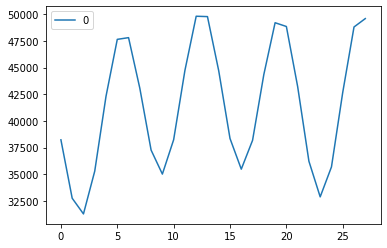

In [124]:
pd.DataFrame(predictions.detach().numpy()[-1]).plot()

In [75]:
actuals_np = actuals.detach().numpy()
predictions_np = predictions.detach().numpy()

indexes = []
preds = []
trues = []

for time_idx in range(1,28):
    indexes.append(time_idx)
    preds.append(predictions_np[time_idx][-1])
    trues.append(actuals_np[time_idx][-1])

fig, ax = plt.subplots()
ax.plot(indexes, preds, color='red', label='forecast')
ax.plot(indexes, trues, color='blue', label='ground truth')
ax.set_title(f"Forecasts at max lead time ({lead_time} samples) - N-BEATS")
ax.legend()

IndexError: index 1 is out of bounds for axis 0 with size 1

In [72]:
actuals_np.shape[1]

28

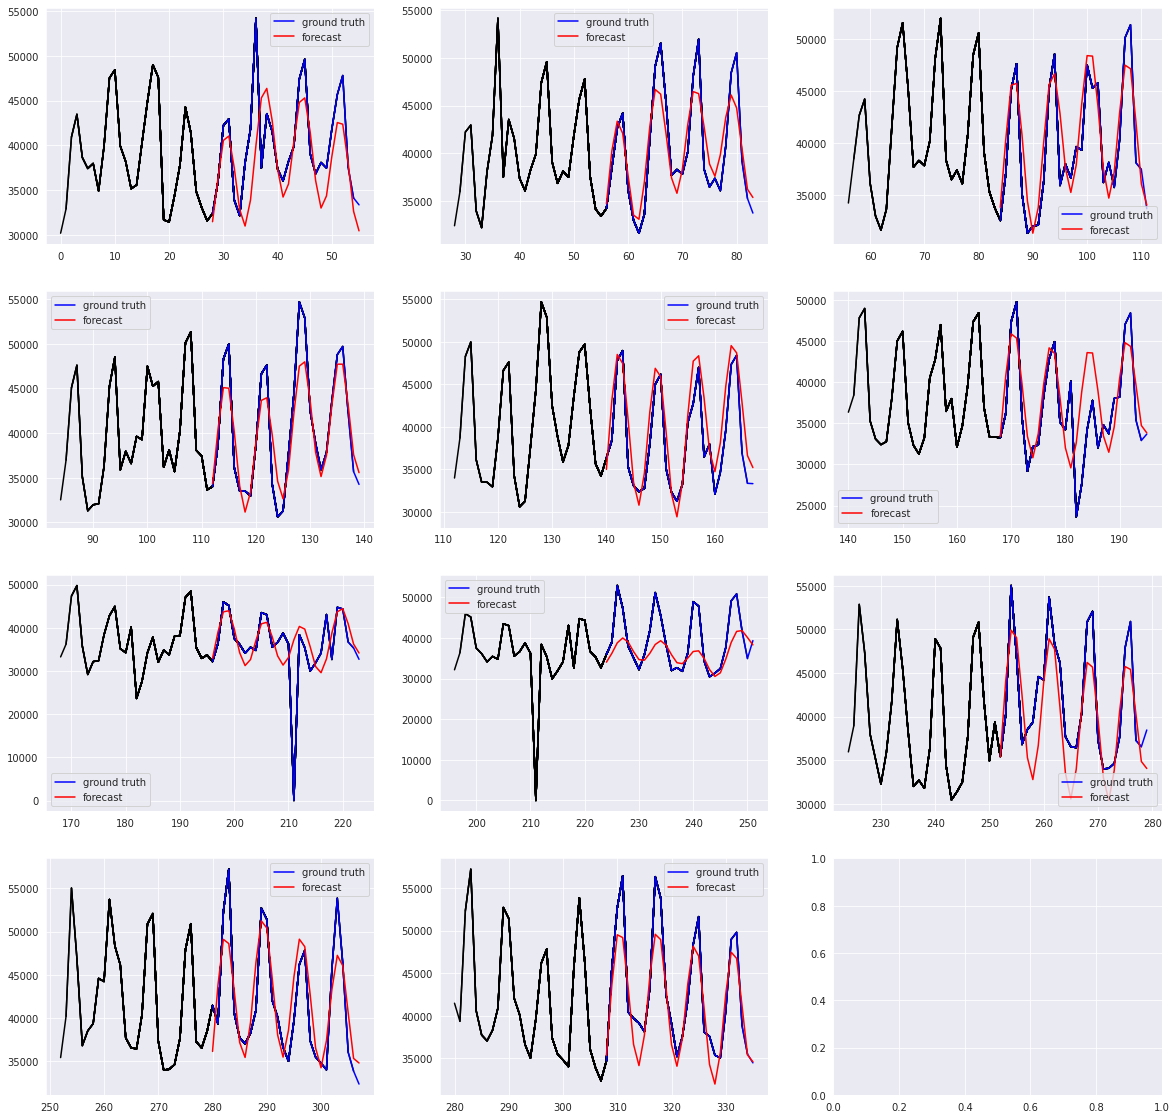

In [36]:
# plot at single time index

fig, axs = plt.subplots(4, 3, figsize=(20,20))
axs = axs.flatten()

for fig_index, example_index in enumerate(range(lag_time, len(predictions_np), lead_time)):

    if fig_index > len(axs) - 1:
        break
    
    n_prev_observations = lag_time
    start_index = example_index - n_prev_observations
    start_index = 0 if start_index < 0 else start_index

    ground_truth = actuals_np[example_index]
    forecast = predictions_np[example_index]

    for index in range(start_index, example_index):
        past_values = actuals_np[index]
        axs[fig_index].plot(list(range(index, index+lag_time)), past_values, color='black')

    index += 1
    axs[fig_index].plot(list(range(index, index+lead_time)), ground_truth, color='blue', label='ground truth')
    axs[fig_index].plot(list(range(index, index+lead_time)), forecast, color='red', label='forecast')
    axs[fig_index].legend()

<AxesSubplot:>

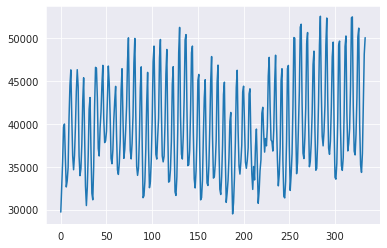

In [48]:
pd.DataFrame(predictions_np)[27].plot()

In [83]:
targets = train_df_nbeats.group_ids.unique()

In [84]:
agg_preds = pd.DataFrame({'id':['F' + str(i + 1) for i in range(28)]})

In [89]:
predictions_np[0]

array([38229.875, 32752.299, 31283.586, 35292.086, 42309.99 , 47648.727,
       47809.07 , 43062.723, 37266.918, 35017.96 , 38238.3  , 44734.81 ,
       49815.93 , 49782.02 , 44695.062, 38354.92 , 35480.2  , 38180.11 ,
       44349.953, 49207.656, 48854.965, 43226.516, 36220.98 , 32882.484,
       35688.33 , 42676.566, 48809.39 , 49595.21 ], dtype=float32)

In [125]:
for target in targets:
    test_dataset = TimeSeriesDataSet(
        test_df,
        time_idx="time_idx",
        target=target,
        group_ids=['group_ids'],
        max_encoder_length=context_length,
        max_prediction_length=max_prediction_length,
        time_varying_unknown_reals=["all"],
    )

    test_dataloader = test_dataset.to_dataloader(train=False, batch_size=1, num_workers=0)

    predictions = best_model.predict(test_dataloader)

    predictions_np = predictions.detach().numpy()
   
    agg_preds[target]=predictions_np[-1]

In [126]:
agg_preds

,id,all,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,...,FOODS,HOBBIES,HOUSEHOLD,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2
0,F1,38229.875000,19248.437500,11620.180664,14186.661133,4931.837891,4866.377441,6717.229492,2766.510010,3501.643311,...,30039.355469,4174.855469,10794.628906,3090.047852,6294.323242,20730.968750,3780.630371,401.405640,8580.662109,2220.790771
1,F2,32752.298828,16868.679688,10521.397461,12334.348633,4238.373535,4098.268066,5957.134277,2544.217529,3141.106445,...,26607.087891,3756.035400,9403.822266,2758.906250,5442.990723,18335.621094,3386.459473,363.001587,7466.864746,1930.710693
2,F3,31283.585938,16108.217773,10170.276367,11742.433594,4016.773926,3852.815186,5714.242188,2473.183105,3025.895264,...,25510.292969,3622.199463,8959.383789,2653.088379,5170.943848,17570.177734,3260.500488,350.729401,7110.946289,1838.014282
3,F4,35292.085938,17707.445312,10908.672852,12987.210938,4482.790527,4368.994141,6225.035645,2622.566406,3268.180664,...,27816.818359,3903.651855,9894.023438,2875.619629,5743.049805,19179.880859,3525.388184,376.537384,7859.431152,2032.951782
4,F5,42309.988281,20665.361328,12274.403320,15289.541016,5344.731445,5323.715332,7169.795410,2898.864502,3716.309570,...,32082.949219,4424.224121,11622.725586,3287.212158,6801.212402,22157.175781,4015.322510,424.271667,9243.824219,2393.506592
5,F6,47648.726562,22940.759766,13325.001953,17060.625000,6007.785645,6058.141113,7896.558105,3111.408691,4061.035889,...,35364.703125,4824.677734,12952.541992,3603.832275,7615.211914,24447.482422,4392.208008,460.991577,10308.777344,2670.865967
6,F7,47809.070312,22944.328125,13326.649414,17063.402344,6008.825684,6059.292969,7897.698242,3111.742188,4061.576660,...,35369.847656,4825.305664,12954.626953,3604.328857,7616.488281,24451.074219,4392.798828,461.049194,10310.448242,2671.301025
7,F8,43062.722656,20723.625000,12301.304688,15334.890625,5361.709473,5342.520508,7188.404297,2904.306885,3725.136475,...,32166.980469,4434.478027,11656.776367,3295.319336,6822.055664,22215.820312,4024.972900,425.211884,9271.092773,2400.608398
8,F9,37266.917969,17953.765625,11022.404297,13178.938477,4554.568848,4448.499023,6303.710938,2645.575195,3305.498779,...,28172.082031,3947.002686,10037.981445,2909.895264,5831.168457,19427.816406,3566.187744,380.512482,7974.717285,2062.977051
9,F10,35017.960938,16722.822266,10454.052734,12220.818359,4195.870117,4051.189697,5910.547363,2530.593018,3119.008789,...,26396.722656,3730.365479,9318.578125,2738.610107,5390.811523,18188.808594,3362.300293,360.647766,7398.599121,1912.931396


<AxesSubplot:title={'center':'all'}>

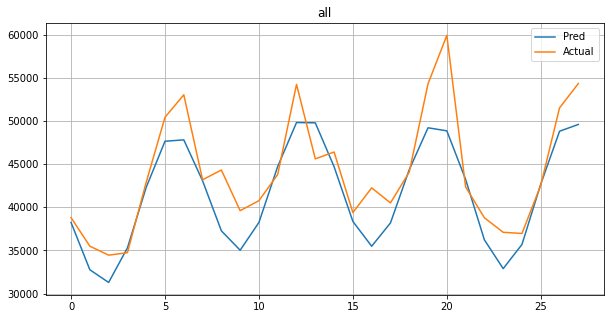

In [167]:
i=0
pd.concat( [agg_preds.iloc[:,i+1], actual_df.reset_index().iloc[:,i+2] ]  , axis=1, ignore_index=True).rename(columns={0:'Pred',1:'Actual'}).plot( y=['Pred', 'Actual'] ,figsize=(10,5), grid=True, title=agg_preds.columns[i+1]  )

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


IndexError: single positional indexer is out-of-bounds

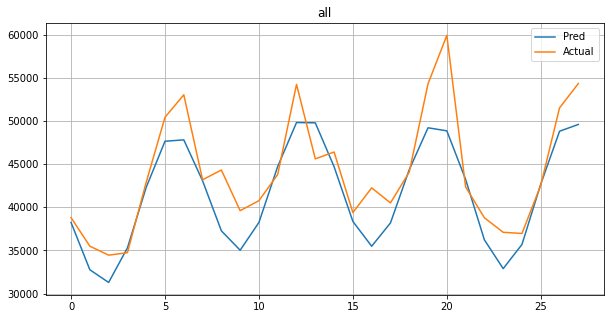

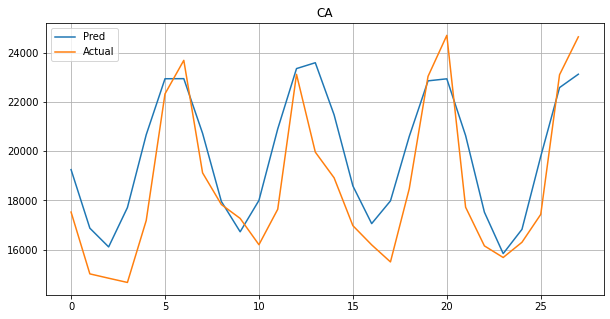

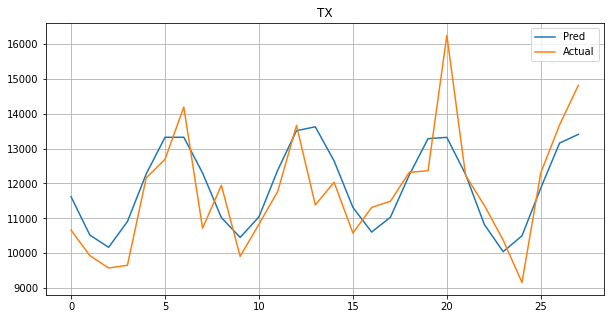

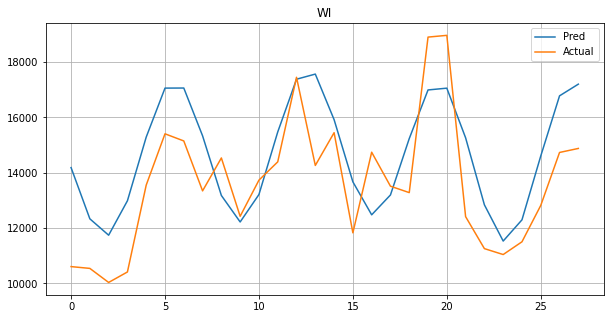

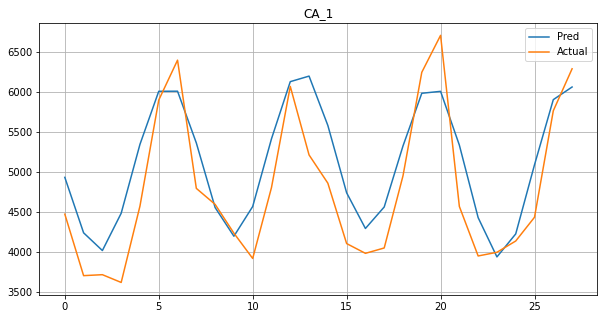

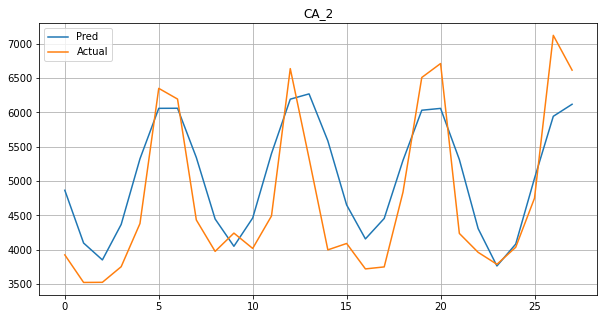

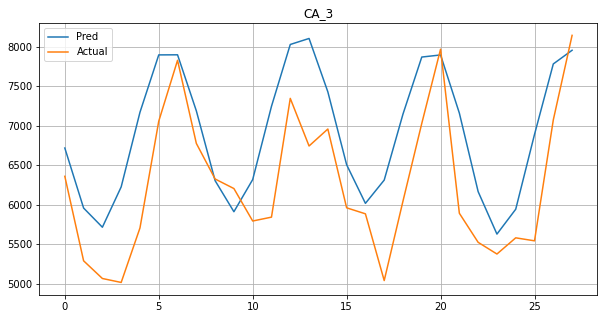

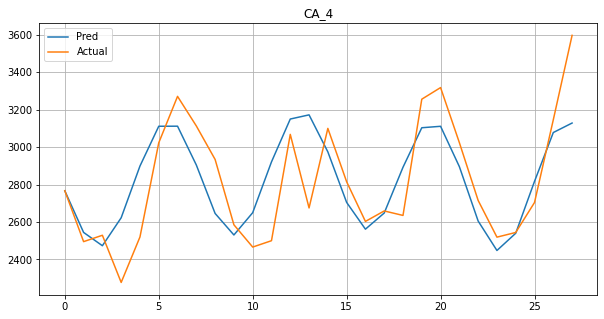

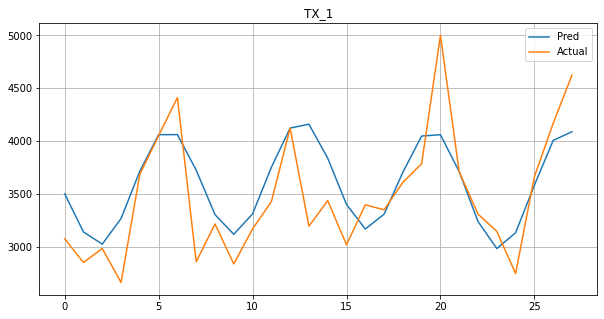

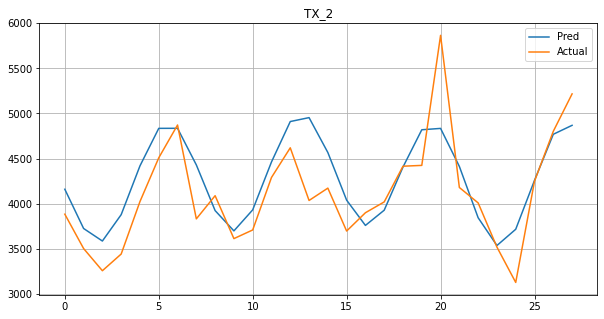

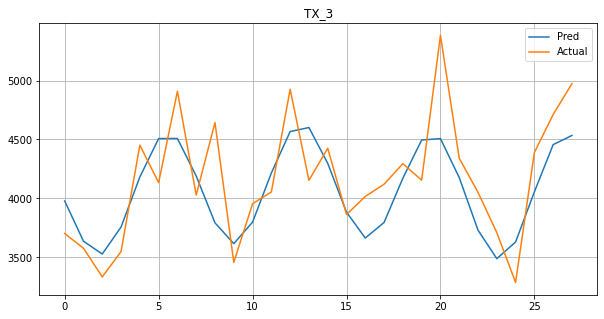

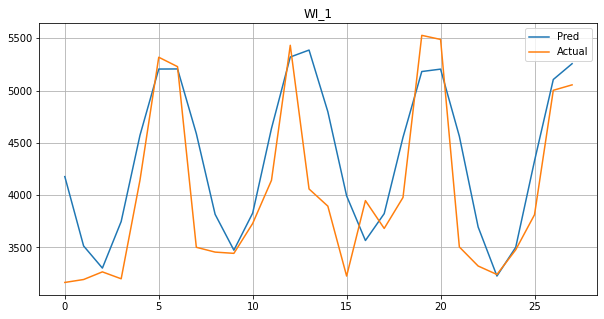

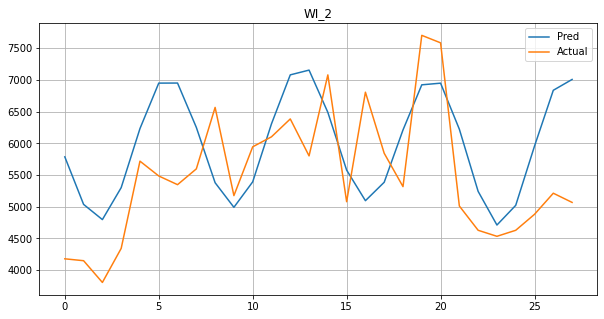

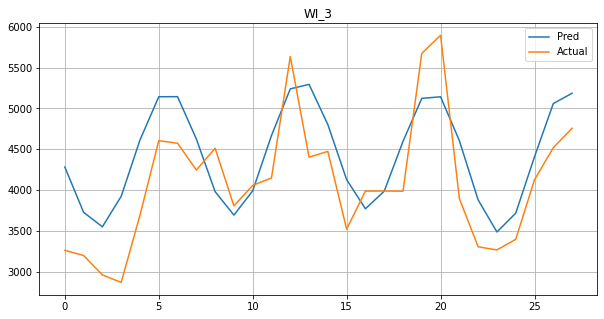

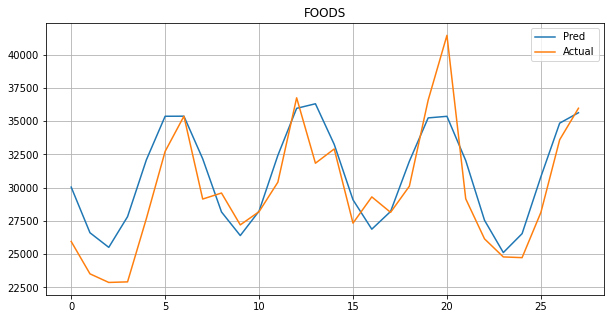

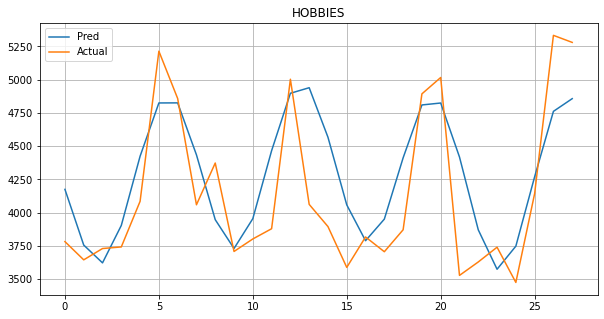

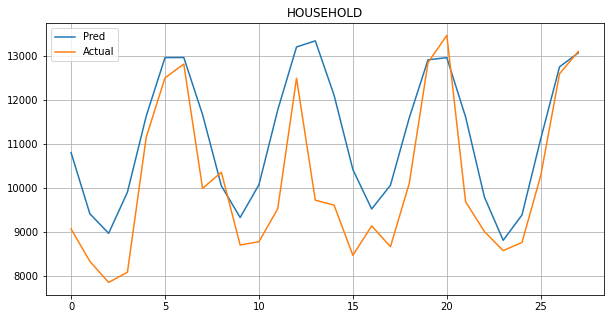

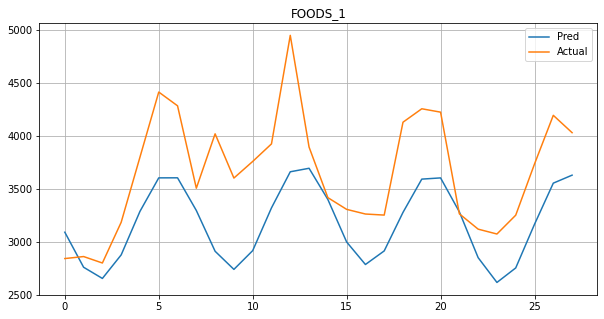

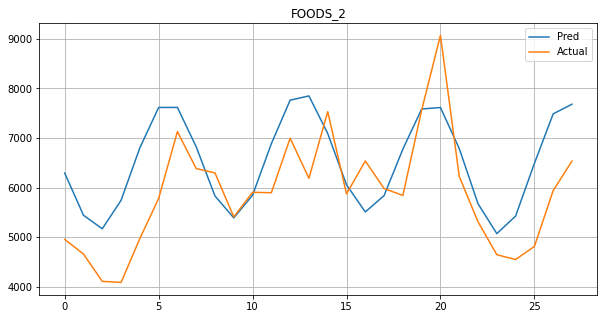

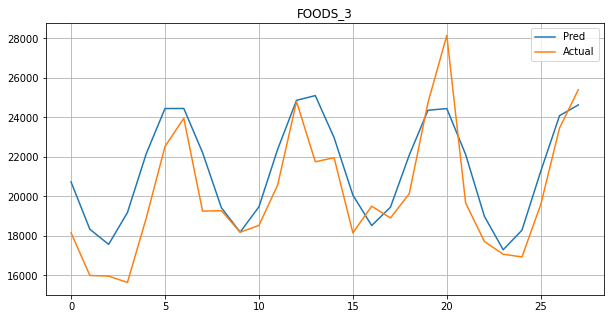

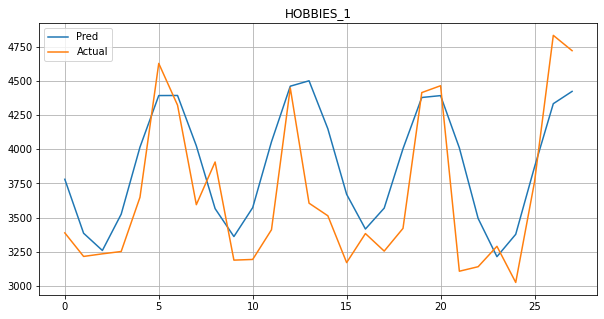

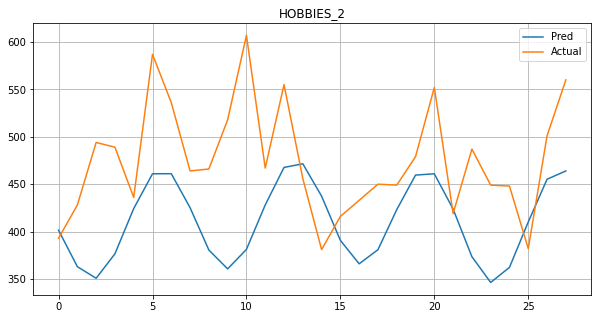

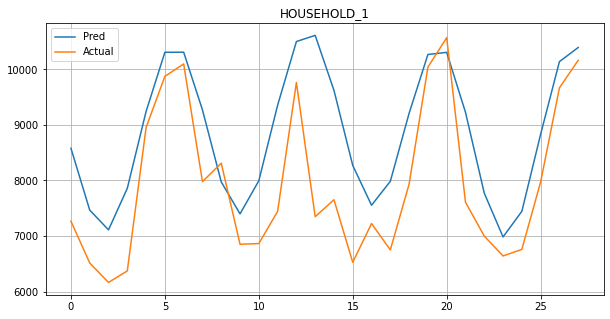

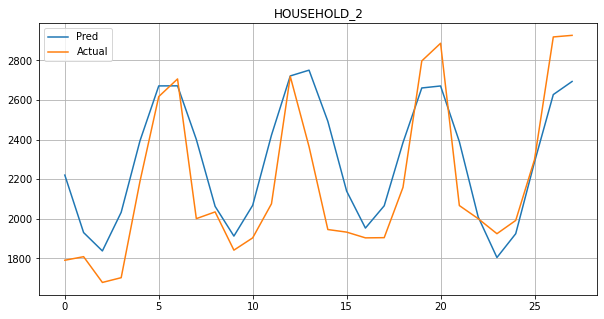

In [169]:
for i in range(0,agg_preds.shape[0]-1):
    (pd.concat([agg_preds.iloc[:,i+1], actual_df.reset_index().iloc[:,i+2]], axis=1, ignore_index=True)
        .rename(columns={0:'Pred',1:'Actual'})
        .plot( y=['Pred', 'Actual'] ,figsize=(10,5), grid=True, title=agg_preds.columns[i+1]  ))

<AxesSubplot:>

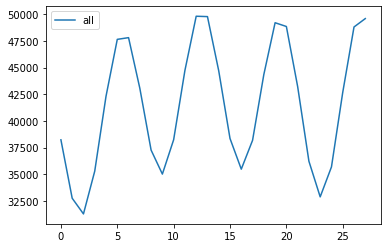

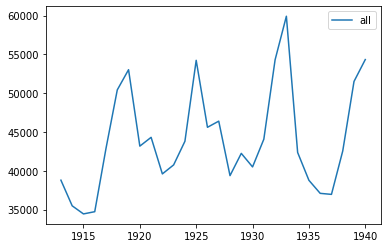

In [127]:
agg_preds[['all']].plot()
actual_df[['all']].plot()

<AxesSubplot:>

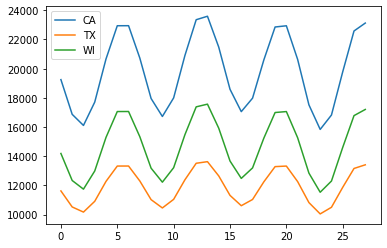

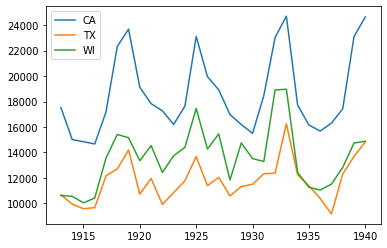

In [128]:
agg_preds[['CA', 'TX', 'WI']].plot()
actual_df[['CA', 'TX', 'WI']].plot()

<AxesSubplot:>

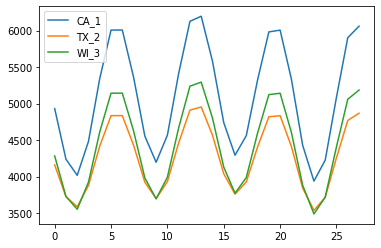

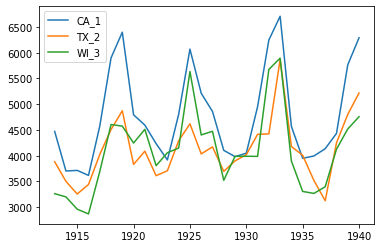

In [129]:
agg_preds[['CA_1', 'TX_2', 'WI_3']].plot()
actual_df[['CA_1', 'TX_2', 'WI_3']].plot()

<AxesSubplot:>

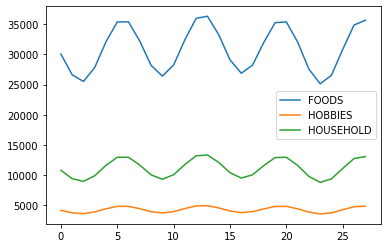

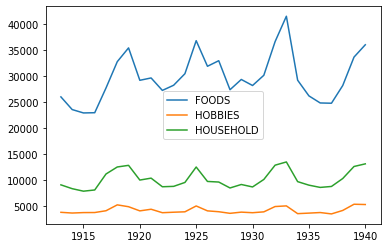

In [130]:
agg_preds[['FOODS', 'HOBBIES', 'HOUSEHOLD']].plot()
actual_df[['FOODS', 'HOBBIES', 'HOUSEHOLD']].plot()

In [82]:
agg_preds.set_index('id').T.to_csv('NBeats_Day3_submission.csv')

In [86]:
len(preds)

334

In [46]:
predictions_np[0][-1]

29714.965

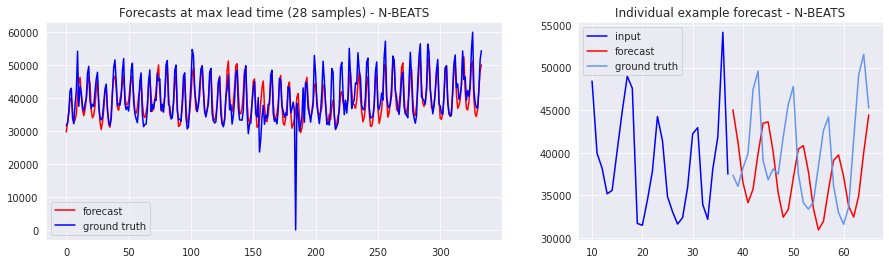

In [33]:
actuals_np = actuals.detach().numpy()
predictions_np = predictions.detach().numpy()

indexes = []
preds = []
trues = []

for time_idx in range(actuals_np.shape[0]):
    indexes.append(time_idx)
    preds.append(predictions_np[time_idx][-1])
    trues.append(actuals_np[time_idx][-1])

sns.set_style('darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,4), gridspec_kw={'width_ratios': [3, 2]})
ax1.plot(indexes, preds, color='red', label='forecast')
ax1.plot(indexes, trues, color='blue', label='ground truth')
ax1.set_title(f"Forecasts at max lead time ({lead_time} samples) - N-BEATS")
ax1.legend()

start = 10
ax2.plot(list(range(start,start+28)), actuals_np[start], color='blue', label='input')
ax2.plot(list(range(start+28, start+56)), predictions_np[start], color='red', label='forecast')
ax2.plot(list(range(start+28, start+56)), actuals_np[start+30], color='cornflowerblue', label='ground truth')
ax2.set_title(f"Individual example forecast - N-BEATS")
ax2.legend(loc='upper left')

plt.show()

In [30]:
test_dataset = TimeSeriesDataSet(
    test_df,
    time_idx="time_idx",
    target="HOUSEHOLD_2",
    group_ids=['group_ids'],
    max_encoder_length=context_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["HOUSEHOLD_2"],
)

test_dataloader = test_dataset.to_dataloader(train=False, batch_size=1, num_workers=0)

In [31]:
#best_model_path = trainer.checkpoint_callback.best_model_path
#best_model = NBeats.load_from_checkpoint(best_model_path)

actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = net.predict(test_dataloader)

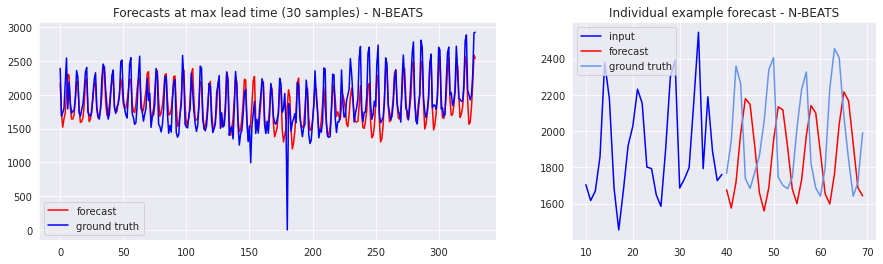

In [32]:
actuals_np = actuals.detach().numpy()
predictions_np = predictions.detach().numpy()

indexes = []
preds = []
trues = []

for time_idx in range(actuals_np.shape[0]):
    indexes.append(time_idx)
    preds.append(predictions_np[time_idx][-1])
    trues.append(actuals_np[time_idx][-1])

sns.set_style('darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,4), gridspec_kw={'width_ratios': [3, 2]})
ax1.plot(indexes, preds, color='red', label='forecast')
ax1.plot(indexes, trues, color='blue', label='ground truth')
ax1.set_title(f"Forecasts at max lead time ({lead_time} samples) - N-BEATS")
ax1.legend()

start = 10
ax2.plot(list(range(start,start+30)), actuals_np[start], color='blue', label='input')
ax2.plot(list(range(start+30, start+60)), predictions_np[start], color='red', label='forecast')
ax2.plot(list(range(start+30, start+60)), actuals_np[start+30], color='cornflowerblue', label='ground truth')
ax2.set_title(f"Individual example forecast - N-BEATS")
ax2.legend(loc='upper left')

plt.show()

In [201]:
net2 = NBeats.from_dataset(
    training,
    learning_rate=5e-4,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    # widths=[16, 16],
    # backcast_loss_ratio=1.0,
)

In [202]:
trainer.fit(
    net2,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.717     Total estimated model params size (MB)
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /ssd003/home/pli/forecasting-bootcamp/Paul_Li_M5/ligh

Validation sanity check: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 42
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [203]:
predictions2 = net2.predict(test_dataloader)

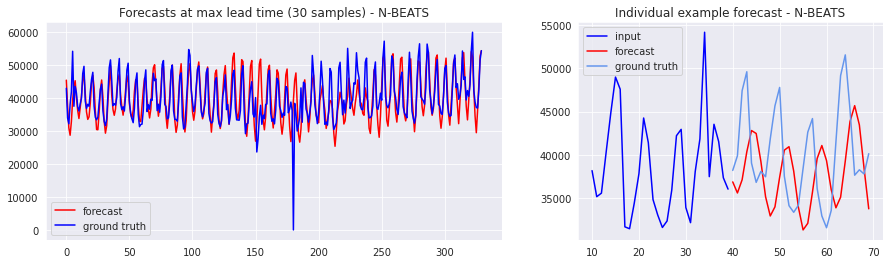

In [204]:
actuals_np = actuals.detach().numpy()
predictions_np = predictions2.detach().numpy()

indexes = []
preds = []
trues = []

for time_idx in range(actuals_np.shape[0]):
    indexes.append(time_idx)
    preds.append(predictions_np[time_idx][-1])
    trues.append(actuals_np[time_idx][-1])

sns.set_style('darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,4), gridspec_kw={'width_ratios': [3, 2]})
ax1.plot(indexes, preds, color='red', label='forecast')
ax1.plot(indexes, trues, color='blue', label='ground truth')
ax1.set_title(f"Forecasts at max lead time ({lead_time} samples) - N-BEATS")
ax1.legend()

start = 10
ax2.plot(list(range(start,start+30)), actuals_np[start], color='blue', label='input')
ax2.plot(list(range(start+30, start+60)), predictions_np[start], color='red', label='forecast')
ax2.plot(list(range(start+30, start+60)), actuals_np[start+30], color='cornflowerblue', label='ground truth')
ax2.set_title(f"Individual example forecast - N-BEATS")
ax2.legend(loc='upper left')

plt.show()